## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import math
import os
import warnings
from random import randint
%matplotlib inline

## Camera calibration using chessboard images

First step is to take 20 to 30 pictures of a chessboard with the camera you will be using on the self driving car. I have placed these images inside `camera_calibration_images`. Then determine

- nx: Number of corners in any given row
- ny: Number of corners in any given column

<b>corners:</b> Points where two black and two white squares intersect.

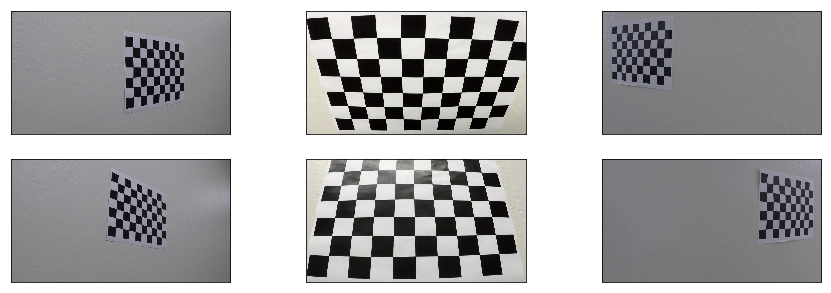

In [3]:
# Make a list of paths to calibration images
cal_img_paths = glob.glob(os.path.join("camera_calibration_images" , "calibration*.jpg"))

# Read and Display samples
plt.figure(figsize=(15, 5))  # width and heights in inches
for i in range( min(6,len(cal_img_paths) )):
    image = mpimg.imread(cal_img_paths[i])
    plt.subplot(2,3,i+1), plt.xticks([]), plt.yticks([])
    plt.imshow(image)

From the above images you can see that my chessboard has nx=9 , ny=6. Now let's define the object points to determine the [camera calibration parameters](https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html).

In [4]:
# Arrays to store object points and image points for each calibration image.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(ny,nx,0) in a column
nx, ny = 9, 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for i in range(len(cal_img_paths)):
    image = mpimg.imread(cal_img_paths[i])
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Camera Calibration Parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("\n Matrix Coefficients \n", mtx)
print("\n Distortion Coefficients [k1 k2 p1 p2 k3] \n",dist)


 Matrix Coefficients 
 [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

 Distortion Coefficients [k1 k2 p1 p2 k3] 
 [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259867]]


## Distortion Correction

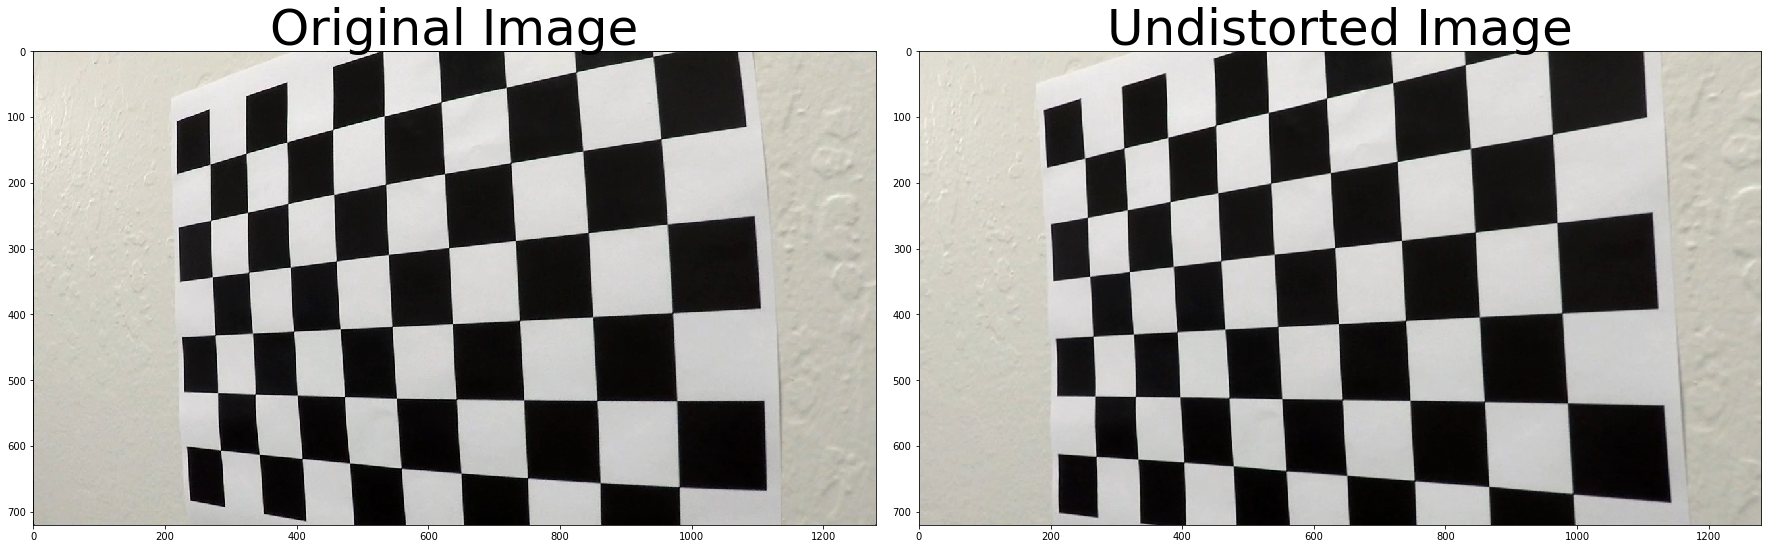

In [5]:
# Undistort random calibration image
indx   = randint(0,len(cal_img_paths))
image  = mpimg.imread(cal_img_paths[indx])
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Read in Test Images
In `Udacity_dataset` there is a `test_images` folder which contains 2 straight line images for aligning perspective transform and 6 other test images. 


 Location  : Udacity_dataset/test_images/straight_lines2.jpg 
 Dimensions: (720, 1280, 3)


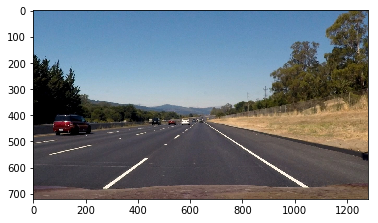

In [6]:
straight_line_test_images_paths = glob.glob(os.path.join("Udacity_dataset","test_images","straight*.jpg"))
test_images_paths = glob.glob(os.path.join("Udacity_dataset","test_images","test*.jpg"))
                              
# Read straight line image
image = mpimg.imread(straight_line_test_images_paths[0]) #first image from list

# Display
print('\n Location  :', straight_line_test_images_paths[0], '\n Dimensions:', image.shape)
plt.imshow(image)

## Apply Perspective Transformation
Next, you want to identify four source points for your perspective transform. The easiest way to do this is to investigate an image where the lane lines are straight. Try experimenting with different src points.

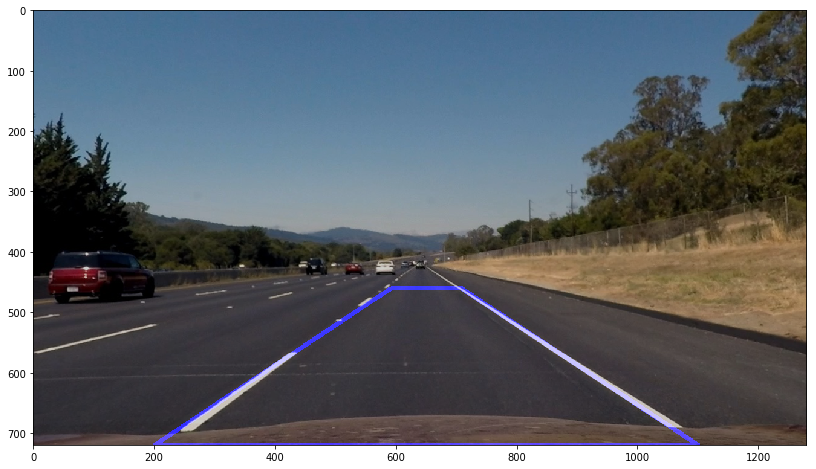

In [37]:
def draw_roi_box(img, vertices, color=[0, 0, 255], thickness=5):
    """
    Draw a contour around region of interest on img (binary or color)
    Vertices must be 2D array of coordinate pairs [[(x1,y1),...,(x4,y4)]]
    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw the lines
    for vertex in vertices:   # used 'for' to get rid of 2D array
        cv2.line(img_to_draw, tuple(vertex[0]), tuple(vertex[1]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[1]), tuple(vertex[2]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[2]), tuple(vertex[3]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[3]), tuple(vertex[0]), color, thickness)
           
    # Add detected lanes to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, 0.8, 0) 
    return output_img


# Read straight line image
image = mpimg.imread(straight_line_test_images_paths[0]) #first image from list
image = cv2.undistort(image, mtx, dist, None, mtx)

# Obtain source points
height, width = image.shape[:2]
offset = 10   # camera offset from center of car
bottom_left   =( width/2 -450 +offset   , height) 
upper_left    =( width/2 -58  +offset   , height/2+100)
upper_right   =( width/2 +58  +offset   , height/2+100)
bottom_right  =( width/2 +450 +offset   , height)
vertices = np.array([[bottom_left,upper_left,upper_right,bottom_right]], dtype=np.int32)

# Display
plt.figure(figsize=(15, 8))  # width and heights in inches
plt.imshow(draw_roi_box(image, vertices))

Now that we have acquired the source points let's apply the perspective transform

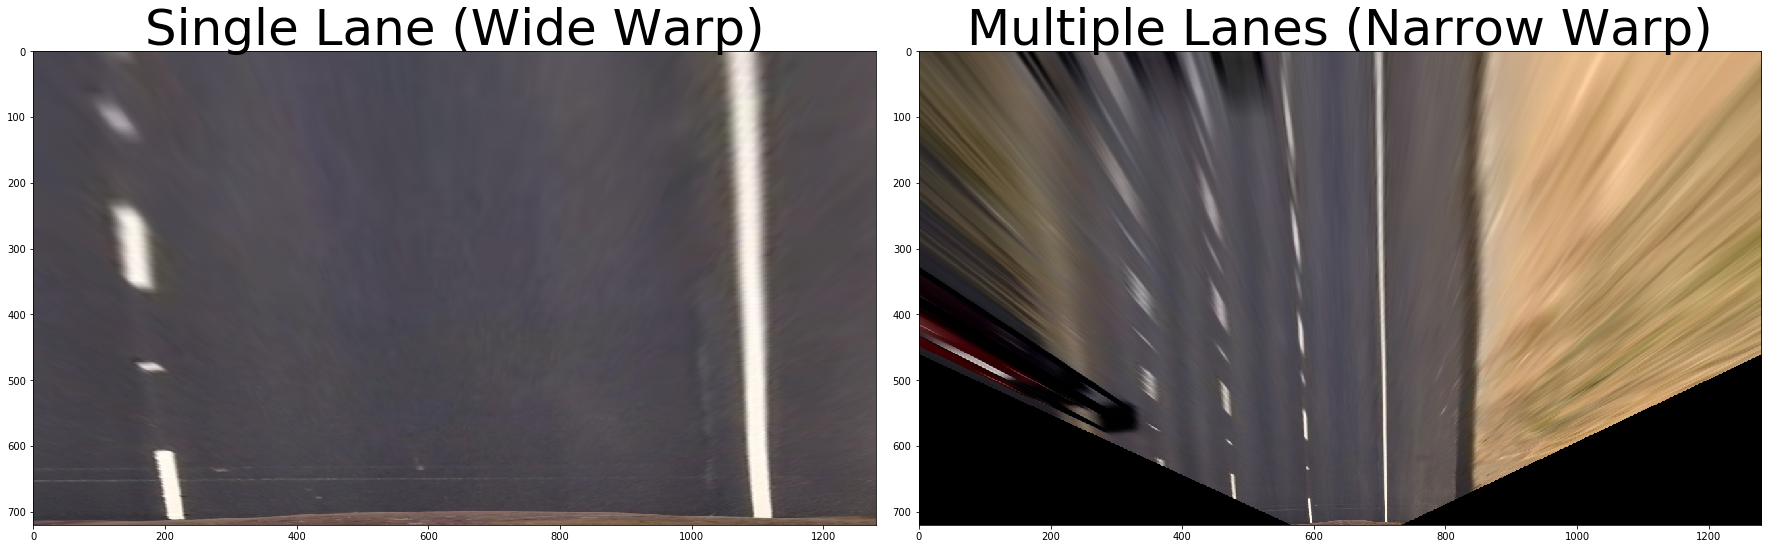

In [45]:
# Source Points
src = np.float32(vertices[0]) # with [0] we reduce one dimension

# Destination Points   
dst_wide = np.float32([bottom_left,
                   [bottom_left[0], 0],
                   [bottom_right[0],0],
                   bottom_right])
dst_narrow = np.float32([[upper_left[0],height],
                         upper_left,
                         upper_right,
                         [upper_right[0],height]])

# Perspective Transform Matrix
M_wide   = cv2.getPerspectiveTransform(src, dst_wide)
M_narrow = cv2.getPerspectiveTransform(src, dst_narrow)

# Warped Images
warped_wide   = cv2.warpPerspective(image, M_wide, (width,height))
warped_narrow = cv2.warpPerspective(image, M_narrow, (width,height))

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax1.imshow(warped_wide)
ax1.set_title('Single Lane (Wide Warp)', fontsize=50)
ax2.imshow(warped_narrow)
ax2.set_title('Multiple Lanes (Narrow Warp)', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Convert to a Thresholded Binary Image

## Helper Functions
Below are some helper functions that will be used in our pipeline.

## Lane Detector Pipeline
Makes use of helper functions to return image with lanes detected.

In [ ]:
https://www.mrt.kit.edu/download/Multi_Lane_Detection_and_Ego_Lane_Estimation(1).pdf

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('test_image.png')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test_image2.png')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(corners.shape, corners[0:3] ,corners[0][0])
    # 4) If corners found: 
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
             #Note: you could pick any four of the detected corners 
             # as long as those four corners define a rectangle
             #One especially smart way to do this would be to use four well-chosen
             # corners that were automatically detected during the undistortion steps
             #We recommend using the automatic detection of corners in your code
             #corners have (x,y) coordinate where y is inverted
        src = np.float32([corners[0][0],corners[7][0],corners[40][0],corners[47][0]])
        # # b2) Make sure corner points chosen look ok
        # plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        # for i, cornerPt in enumerate(src):
        #     x,y = cornerPt
        #     print(x,y)
        #     plt.plot(x, y ,'.')
        #     y_text = y-5 if y-5<0 else y+5 
        #     plt.text(x, y_text, str(i))
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[100,100],[1200,100],[100,850],[1200,850]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        h , w = undist.shape[0:2]
        warped = cv2.warpPerspective(undist, M, (w,h), flags=cv2.INTER_LINEAR)

    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
